## Implementing Autoencoders using Keras

In this lab lesson, we will look into the implementation of Autoencoders using Keras. The tutorial is based on the code provided by https://blog.keras.io/building-autoencoders-in-keras.html.

## Load MNIST Dataset
Load MNIST dataset from keras.datasets

In [78]:
import keras
from keras import layers
from keras.datasets import mnist
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# print("=============================================================")
# print("Before Conversion:")
# print(x_train.shape)
# print(x_test.shape)
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print("=============================================================")
# print("After Conversion:")
# print(x_train.shape)
# print(x_test.shape)
# print("=============================================================")

## Helper Functions
Defining helper functions to plot the results

In [137]:
#Function to plot loss and accuracy curves
def plot_curve(log):
    N_train = len(log.history['loss'])
    N_valid = len(log.history['val_loss'])
    
    plt.figure(figsize=(18,4))
    
    # Plot loss on training and validation set
    plt.plot(log.history['loss'])
    plt.plot(np.linspace(0,N_train-1,N_valid), log.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid('on')
    plt.legend(['Train', 'Validation'])
    
    plt.show()

def pred(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def denoise_pred(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def cifar(x,y):
    n = 10 
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(y[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Image Denoising using Fully Convolutional Autoencoder

### Reshaping data and Preparing Noisy Data 

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(50000, 32, 32, 3)


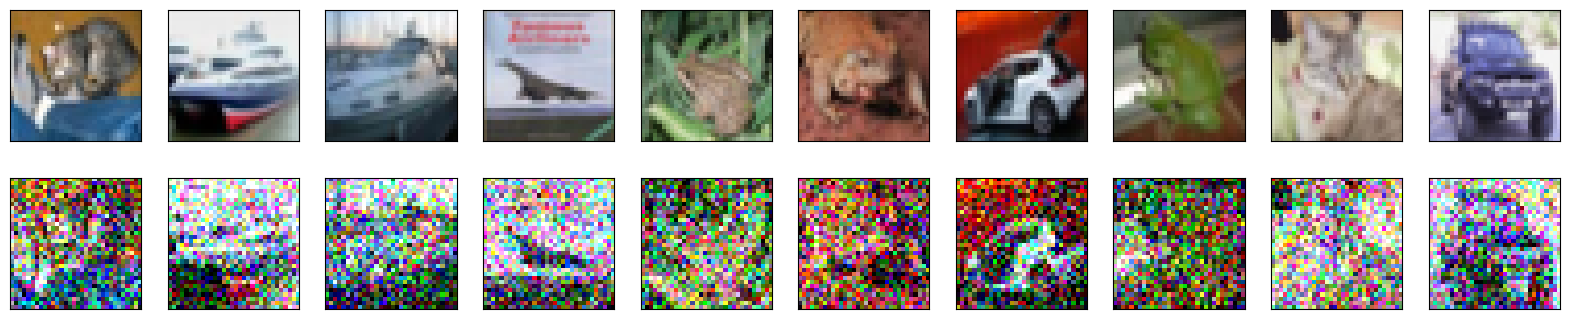

In [124]:

x_train = x_train.reshape((len(x_train), 32,32,3))
x_test = x_test.reshape((len(x_test), 32,32,3))
print(x_train.shape)
print(x_test.shape)


def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)

# Reshape grayscale images to (num_samples, 32, 32, 1)
x_train_gray = x_train_gray.reshape((len(x_train), 32, 32, 1))
x_test_gray = x_test_gray.reshape((len(x_test), 32, 32, 1))

noise_factor = 0.3
x_train_noisy = x_train_gray + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_gray.shape) 
x_test_noisy = x_test_gray + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_gray.shape) 

x_train_noisyRGB = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisyRGB = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


print(x_train_noisyRGB.shape)

cifar(x_test,x_test_noisyRGB)

### Model Definition

In [135]:
#define encoder network
encoder1 = keras.Sequential(name='Encoder_CNN')
encoder1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,1), name='E1'))
encoder1.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encoder1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='E3'))
encoder1.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
encoder1.summary()

#define decoder network
decoder1 = keras.Sequential(name='Decoder_CNN')
decoder1.add(layers.Conv2DTranspose(32, (3, 3), input_shape=(8,8,32),activation='relu', padding='same', strides=2, name='D1'))
decoder1.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2, name='D2'))
decoder1.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Output'))
decoder1.summary()

#define autoencoder by combining encoder and decoder
input_img = keras.Input(shape=(32,32,1), name='Input_Layer')
z = encoder1(input_img)
output_img = decoder1(z)
autoencoder1 = keras.models.Model(inputs=input_img, outputs=output_img, name='Fully_Convolutional_Autoencoder')
autoencoder1.summary()

Model: "Encoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 E1 (Conv2D)                 (None, 32, 32, 32)        320       
                                                                 
 E2 (MaxPooling2D)           (None, 16, 16, 32)        0         
                                                                 
 E3 (Conv2D)                 (None, 16, 16, 32)        9248      
                                                                 
 E4 (MaxPooling2D)           (None, 8, 8, 32)          0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 D1 (Conv2DTranspose)        (No

### Model Training

Epoch 1/20
352/352 [==============================] - 16s 43ms/step - loss: 0.6011 - val_loss: 0.5922
Epoch 2/20
352/352 [==============================] - 15s 43ms/step - loss: 0.5899 - val_loss: 0.5907
Epoch 3/20
352/352 [==============================] - 14s 40ms/step - loss: 0.5888 - val_loss: 0.5902
Epoch 4/20
352/352 [==============================] - 14s 40ms/step - loss: 0.5883 - val_loss: 0.5896
Epoch 5/20
352/352 [==============================] - 14s 41ms/step - loss: 0.5879 - val_loss: 0.5894
Epoch 6/20
352/352 [==============================] - 14s 41ms/step - loss: 0.5876 - val_loss: 0.5890
Epoch 7/20
352/352 [==============================] - 14s 41ms/step - loss: 0.5872 - val_loss: 0.5887
Epoch 8/20
352/352 [==============================] - 14s 41ms/step - loss: 0.5869 - val_loss: 0.5885
Epoch 9/20
352/352 [==============================] - 14s 41ms/step - loss: 0.5866 - val_loss: 0.5882
Epoch 10/20
352/352 [==============================] - 15s 41ms/step - loss: 0.586

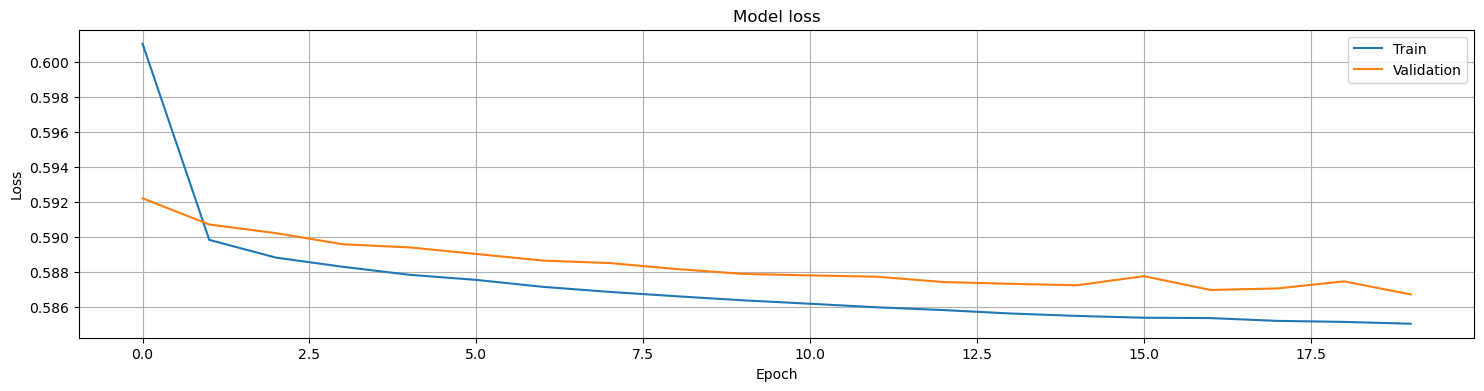

In [136]:
#Configure the model for training
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

#Model Training
log = autoencoder1.fit(x_train_noisy, x_train_gray, epochs=20, batch_size=128, shuffle=True, validation_split=0.1)

#Plot loss curves
plot_curve(log)

### Display Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

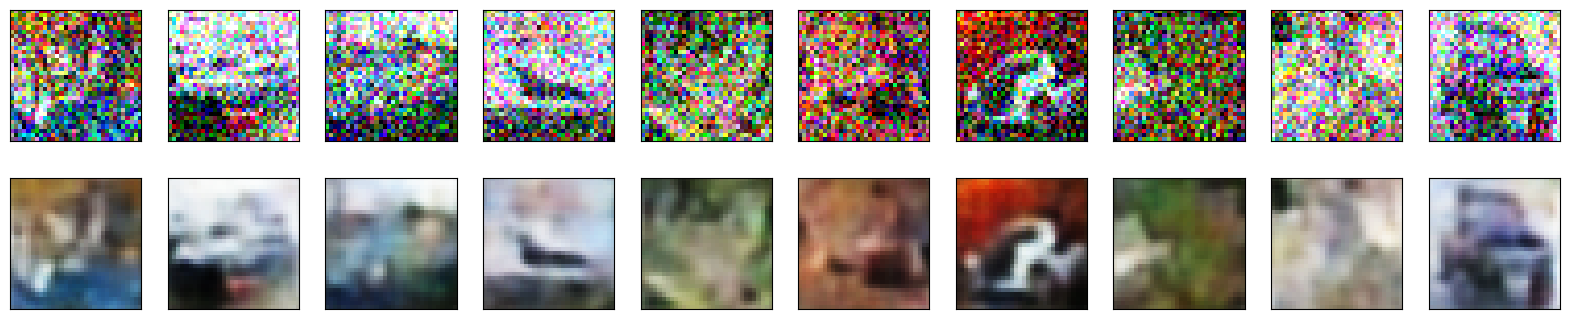

In [134]:
#Get the encoded values for test images
encoded_img = encoder1(x_test_noisyRGB)

#Get the decoded images from the encoded values
decoded_img = decoder1(encoded_img)

#Plot test and decoded images
denoise_pred(decoded_img.numpy())



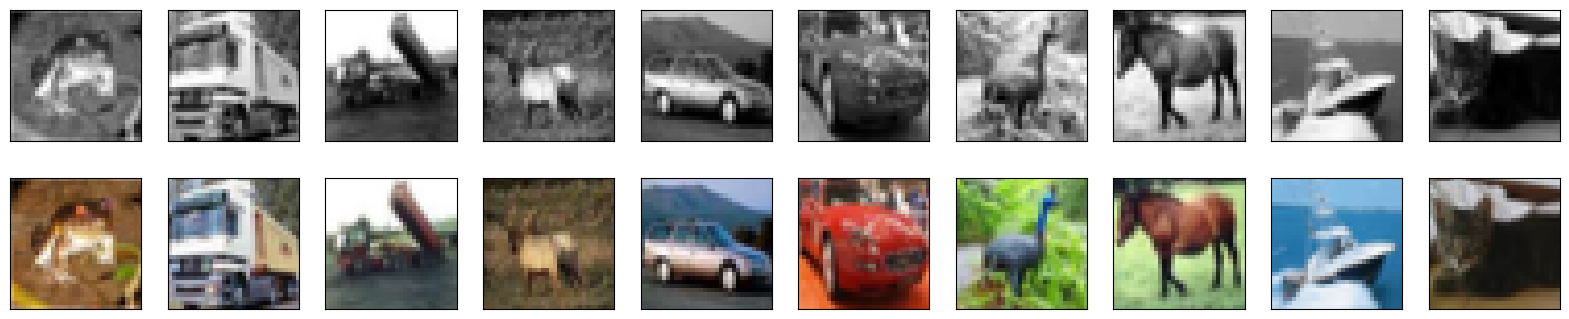

In [39]:
import numpy as np
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


x_train_gray = rgb_2_gray(x_train)
x_test_gray = rgb_2_gray(x_test)
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.
x_train_gray = x_train_gray.reshape((len(x_train), 32,32,1))
x_test_gray = x_test_gray.reshape((len(x_test), 32,32,1))

cifar(x_train_gray, x_train)

### Model Definition

In [49]:
#define encoder network
encoder2 = keras.Sequential(name='Encoder_CNN')
encoder2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,1), name='E1'))
encoder2.add(layers.MaxPooling2D((2, 2), padding='same', name='E2'))
encoder2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='E3'))
encoder2.add(layers.MaxPooling2D((2, 2), padding='same', name='E4'))
encoder2.summary()

#define decoder network
improved_decoder = keras.Sequential(name='Decoder_CNN')
improved_decoder.add(layers.UpSampling2D((2, 2), input_shape=(8, 8, 32), name='UpSampling'))
improved_decoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='D1'))
improved_decoder.add(layers.UpSampling2D((2, 2), name='UpSampling2'))
improved_decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='D2'))
improved_decoder.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='Output'))

# Combine encoder and improved decoder
input_img = keras.Input(shape=(32, 32, 1), name='Input_Layer')
z = encoder2(input_img)
output_img = improved_decoder(z)
autoencoder3 = keras.models.Model(inputs=input_img, outputs=output_img, name='Improved_Autoencoder')
autoencoder3.summary()

Model: "Encoder_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 E1 (Conv2D)                 (None, 32, 32, 32)        320       
                                                                 
 E2 (MaxPooling2D)           (None, 16, 16, 32)        0         
                                                                 
 E3 (Conv2D)                 (None, 16, 16, 32)        9248      
                                                                 
 E4 (MaxPooling2D)           (None, 8, 8, 32)          0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________
Model: "Improved_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLaye